In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import os
from PIL import Image
import hshap
import pandas as pd
import seaborn as sns

In [2]:
# select device
# uncomment the following line to specify which GPU you want to use
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# load pretrained model
torch.manual_seed(0)
model = models.resnet18(pretrained=False)
# change last layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
# load saved weights
model.load_state_dict(torch.load("model.pth", map_location=device))
# move model to device and set inference mode
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# compose transform
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# uncomment this code to compute the baseline
# data_dir = **YOUR_DATA_DIRECTORY_ABSOLUTE_PATH**
# train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform)
# dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
# _iter = iter(dataloader)
# X, _ = next(_iter)
# ref = X.detach().mean(0)
# or simply load the packaged reference
ref = torch.load("reference.pth")
ref = ref.to(device)

# initialize h-Shap explainer
s = 40
hexp = hshap.src.Explainer(model, ref, min_size=s)

Explaining image 1f8f08ea-b5b3-4f68-94d4-3cc071b7dce8.png with relative thresholding and t=70.0
Done in 3.131412s


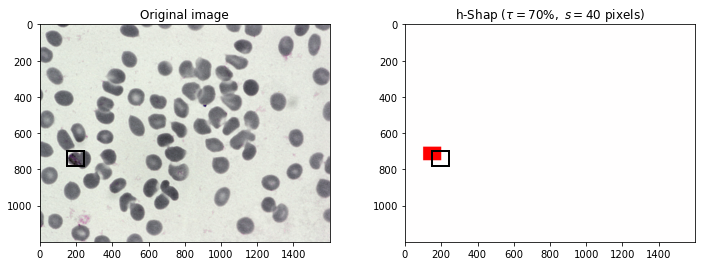

Explaining image 2ac343e4-c889-47c1-8fe2-461b626def76.png with relative thresholding and t=70.0
Done in 2.6394s


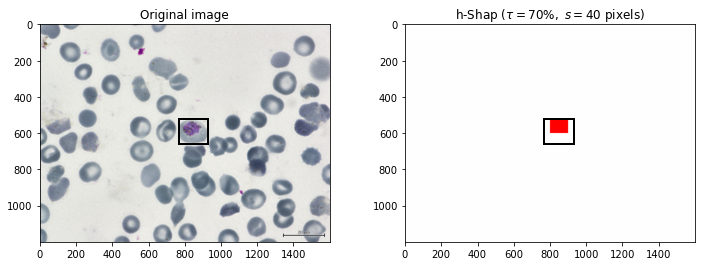

Explaining image 2bd15b6e-fe2d-49f3-b394-940d024d1f91.png with relative thresholding and t=70.0
Done in 3.770205s


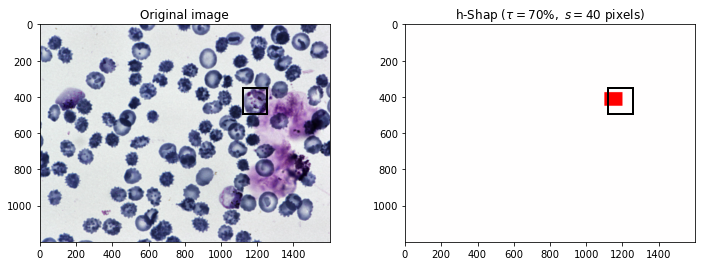

Explaining image 32700bc7-7a86-49d3-aded-ccaaed4ddc5c.png with relative thresholding and t=70.0
Done in 3.740363s


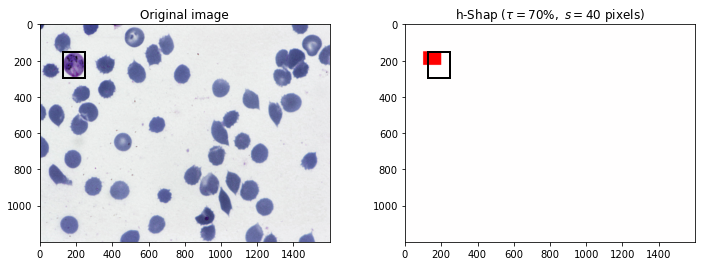

Explaining image 38d1b930-dd97-4248-9160-e9389a1a8dd7.png with relative thresholding and t=70.0
Done in 2.862129s


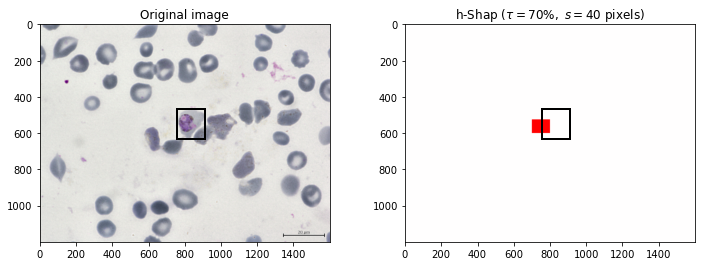

Explaining image 471f75c6-bd5d-4c20-bcc1-258e836f4d69.png with relative thresholding and t=70.0
Done in 3.249025s


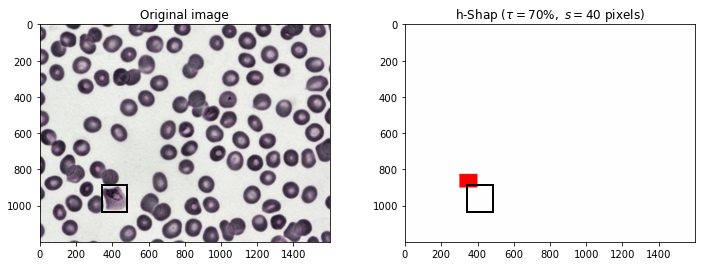

In [4]:
# define thresholding modes
thresholds = ["relative_70"]

# load annoations
annotations = pd.read_json("annotations.json")


def annotate(ax, filename):
    query = annotations.loc[annotations["image"] == filename]
    for i, row in query.iterrows():
        trophozoites = row["objects"]
        for trophozoite in trophozoites:
            bbox = trophozoite["bounding_box"]
            upper_left_r = bbox["minimum"]["r"]
            upper_left_c = bbox["minimum"]["c"]
            lower_right_r = bbox["maximum"]["r"]
            lower_right_c = bbox["maximum"]["c"]
            w = np.abs(lower_right_c - upper_left_c)
            h = np.abs(lower_right_r - upper_left_r)
            # Create a Rectangle patch
            rect = patches.Rectangle(
                (upper_left_c, upper_left_r),
                w,
                h,
                linewidth=2,
                edgecolor="k",
                facecolor="none",
            )
            # Add the patch to the Axes
            ax.add_patch(rect)


# for each example image
for (dirpath, _, filenames) in os.walk("images"):
    for filename in filenames:
        # setup figure
        fig = plt.figure(figsize=(12, 4))
        axes = fig.subplots(1, 2)
        # load and transform image
        image_path = os.path.join(dirpath, filename)
        image = Image.open(image_path)
        image_t = transform(image)
        # show original image
        ax = axes[0]
        ax.imshow(image)
        annotate(ax, filename)
        ax.set_title("Original image")
        # for each threshold mode
        for i, threshold in enumerate(thresholds):
            # set thresholding params
            threshold_params = threshold.split("_")
            threshold_mode = threshold_params[0]
            threshold = float(threshold_params[1])
            # explain image
            print(
                f"Explaining image {filename} with {threshold_mode} thresholding and t={threshold}"
            )
            t0 = time.time()
            explanation, leafs = hexp.explain(
                image_t, label=1, threshold_mode=threshold_mode, threshold=threshold
            )
            t = time.time()
            runtime = np.around(t - t0, decimals=6)
            print(f"Done in {runtime}s")
            # show results
            ax = axes[i + 1]
            _abs = np.abs(explanation.flatten())
            _max = max(_abs)
            ax.imshow(explanation, cmap="bwr", vmax=_max, vmin=-_max)
            annotate(ax, filename)
            ax.set_title(
                r"h-Shap ($\tau = %.0f%s,~s = %d$ pixels)"
                % (threshold, "\%" if threshold_mode == "relative" else "", s)
            )
        img_id = filename.split(".")[0]
        plt.savefig(os.path.join("explanations", f"{img_id}.jpg"))
        plt.show()
        plt.close()